# Processing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from nltk.stem.snowball import FrenchStemmer
from stop_words import get_stop_words
import string
from wordcloud import WordCloud
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

In [5]:
# plt.rcParams['text.color'] = 'black'
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]
# needed for tokenization
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# You need the averaged_perceptron_tagger resource to determine the context of a word in a sentence.

[nltk_data] Downloading package punkt to /Users/DARE/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/DARE/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
df = pd.read_csv("datasets/booking_comments.csv", na_values=['None', 'none'], decimal=',', encoding="utf8", escapechar='\\')

In [7]:
df.head(5)

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Hôtel,Paris,8.2
1,Guillaume,France,0.0,2019-06-21 00:00:00,Superbe,Ce client n'a pas laissé de commentaire.,NaN,8.8,Hôtel,Cannes,7.1
2,Isabelle,France,0,2019-09-09 00:00:00,Déçu par rapport aux descriptifs je ne recomma...,petit déjeuner très peu de choix et servis jus...,"Dans la chambre un éclairage plus tamisé,dans ...",5.0,Hôtel,Nantes,8.0
3,Laura,France,0.0,2019-03-01 00:00:00,Bien,Ce client n'a pas laissé de commentaire.,NaN,7.9,Appart'hôtel,Cannes,6.6
4,Anonyme,France,0.0,2019-06-07 00:00:00,Bien,La baignoire sur pieds dans la chambre.. comme...,Le rapport qualité/prix.. Mais bon Paris est P...,7.0,Hôtel,Paris,7.6


In [8]:
print(f'Le dataset a {df.shape[0]} lignes et {df.shape[1]} colonnes.')

Le dataset a 50814 lignes et 11 colonnes.


### Statistiques descriptives

In [9]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,50070,50007,50786,50071,49958,43726,32214,50064.000000,50814,50814,50814.000000
unique,9367,143,4,1235,14382,25709,28947,NaN,12,6,NaN
top,Anonyme,France,0.0,2020-02-16 00:00:00,Passable,Ce client n'a pas laissé de commentaire.,Rien,NaN,Hôtel,Paris,NaN
freq,5023,43017,29267,204,5547,11838,725,NaN,42688,25396,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.497633,NaN,NaN,7.693083
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.277708,NaN,NaN,0.908541
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,3.900000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.600000,NaN,NaN,7.200000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.200000,NaN,NaN,7.900000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.800000,NaN,NaN,8.300000


## Sélection des variables

Notre objectif est de savoir si un commentaire est positif ou négatif.

Dans notre analyse, on partira sur 2 hypothèses pour déterminer la polarité des commentaires:  
   - calcul de la polarité des commentaires récoltés
   - utilisation de la colonne note pour déterminer la polarité (target déjà fourni par Booking)
    
On conservera donc toutes les variables qui constituent le commentaire final et la note associée.
- **TITRE**, 
- **BONS POINTS**
- **MAUVAIS POINTS**
- **NOTE**

In [10]:
data = df.drop(['nom', 'pays', 'favorite', 'date', 'type_etablissement', 'lieu', 'note_etablissement'], axis= 1)

data.head()

,titre,bons_points,mauvais_points,note
0,NaN,NaN,NaN,NaN
1,Superbe,Ce client n'a pas laissé de commentaire.,NaN,8.8
2,Déçu par rapport aux descriptifs je ne recomma...,petit déjeuner très peu de choix et servis jus...,"Dans la chambre un éclairage plus tamisé,dans ...",5.0
3,Bien,Ce client n'a pas laissé de commentaire.,NaN,7.9
4,Bien,La baignoire sur pieds dans la chambre.. comme...,Le rapport qualité/prix.. Mais bon Paris est P...,7.0


## Traitement des valeurs manquantes

In [11]:
data.isna().sum()

titre               856
bons_points        7088
mauvais_points    18600
note                750
dtype: int64

In [12]:
# we delete empty rows
data = data.dropna(how='all')

# we delete the rows where the note is null
# since we have 2 hypothesis that we want to test and removing 750 rows over 50k we still have plenty of data
data = data.loc[data.note.notna()]

# in the titre, bons_points and mauvais points columns we replace nan by empty strings
data = data.fillna('')

data.isna().sum()

titre             0
bons_points       0
mauvais_points    0
note              0
dtype: int64

On décide aussi de retirer les commentaires générés par Booking 

In [13]:
# replace automatic comments by booking by empty strings
commentaires_booking = ["Ce commentaire n'apparaît pas car il ne respecte pas notre charte.", "Ce client n'a pas laissé de commentaire."]
data.bons_points.loc[data.bons_points.isin(commentaires_booking)] = ''
data.mauvais_points.loc[data.mauvais_points.isin(commentaires_booking)] = ''

/Users/DARE/Documents/simplon/booking_sentiment_analysis/venv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Concaténation des colonnes Titre, Bons Points et Mauvais Points

In [14]:
# merge columns
data['review'] = data.titre + ' ' + data.bons_points + ' ' + data.mauvais_points
data = data[['review', 'note']]
data

,review,note
1,Superbe,8.8
2,Déçu par rapport aux descriptifs je ne recomma...,5.0
3,Bien,7.9
4,Bien La baignoire sur pieds dans la chambre.....,7.0
5,Pas content ! Pas grand-chose !\nLit assez con...,4.0
...,...,...
50808,"Bon acceuil, très bon rapport qualité, prix! B...",10.0
50809,Fabuleux Hôtel proche de la Gare Montparnasse...,9.2
50811,Un séjour médiocre La localisation et le perso...,4.0
50812,Arrivé le soir à 22h30 et reparti le lendemain...,9.2


## Proportion de commentaires positifs / négatifs

Pour éviter d'avoir un modèle biaisé, on va observer si les commentaires sont équilibrés en fonction de leur note

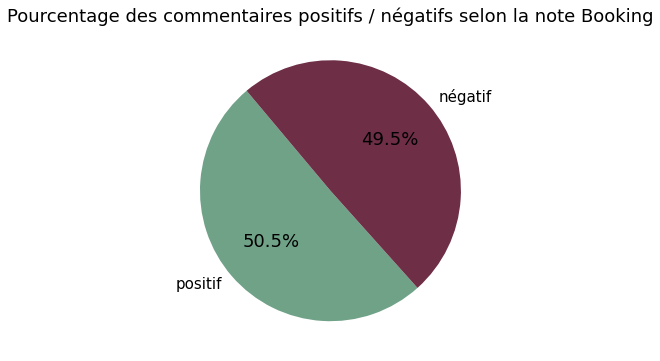

In [15]:
#diagramme circulaire des modalités de la polarité des commentaires
data_percentages = data.note.groupby(data.note > 6).size() / data.shape[0]

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs / négatifs selon la note Booking", fontsize=18)
labels = ['positif', 'négatif']
sizes = [data_percentages[1], data_percentages[0]]

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=130, colors = ['#70A288', '#6D2E46'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

These steps can be pretty long for a large dataset so we will keep only 10000 comments, 5000 positive and 5000 negative.

In [16]:
df_neg = data.loc[data.note < 6]
df_neg.shape

(24474, 2)

In [17]:
df_pos = data.loc[data.note >= 6]
df_pos.shape

(25590, 2)

In [18]:
df_small = pd.concat([df_pos[:5000], df_neg[:5000]], axis=0)
display(df_small.head())
display(df_small.tail())

,review,note
1,Superbe,8.8
3,Bien,7.9
4,Bien La baignoire sur pieds dans la chambre.....,7.0
7,"Bien Le personnel très agréable , bonne liter...",7.5
9,Bien,7.0


,review,note
10412,Passable Lit Etroit pour 2 Le service de netto...,5.0
10418,"séjour possible, mais on n'a pas vraiment envi...",5.0
10421,Assez médiocre L'emplacement,3.0
10422,Décevant,4.2
10425,Horrible La chambre était affreuse ...vieille ...,5.0


## Comment préparer son dataset dans un projet NLP ?

Pour optimiser notre modélisation, on souhaite **conserver seulement les mots / caractères les plus pertinents pour déterminer la polarité d'un commentaire**. 

4 étapes :

- tokenisation
- retrait des stop words
- lemmatisation
- stemming

### 1 - Tokenisation

Pour faciliter la compréhension du language naturel par la machine, on doit transformer nos chaînes de caractères en tokens.

>**tokens** : mots, ponctuation, symboles

La tokenisation basique consiste à séparer le texte par les espaces et la ponctuation. 

In [19]:
get_review_tokens = [word_tokenize(review) for review in df_small.review]

### 2 - retrait des stop words

Les conjonctions de coordinations et la ponctuation n'apporte pas d'information pertinente donc pour améliorer la vitesse du modèle on peut les retirer et éviter d'influencer le modèle par leur présence, on les retire. 

In [20]:
# 'ne' / 'pas' can't be stop words, they have meaning
stop_words = get_stop_words('french').copy() 
stop_words.remove('ne')
stop_words.remove('pas')

In [21]:
def remove_stopwords(review, stopwords):
    #remove punctuation
    ponctuations = string.punctuation
    p = re.compile(r'\.+')
    
    # remove stop words, ellipsis, punctuation and words which length is below 2 and numbers
    review = [p.sub(r'', word).lower() for word in review if word.lower() not in stop_words and word not in ponctuations and not word.isnumeric() and len(word) > 2]
    
    # remove empty strings
    review = filter(None, review)
    
    return ' '.join(review)

In [22]:
cleaned_review_tokens = [remove_stopwords(review, stop_words) for review in get_review_tokens]

### 3 -Normalization : stemmatisation & lemmatization

La normalisation en NLP consiste à conserver la forme canonique des mots du corpus. On peut utiliser deux méthodes : la lemmatization et le stemmatisation

#### Lemmatization 

La lemmatization consiste à analyser le mot selon le contexte d'utilisation et le remplacer par une forme normalisée.

**1 - Etiquetage morpho-syntaxique**

On détermine le contexte d'utilisation grâce à l'étiquetage morpho-syntaxique (Part-Of-Speech - POS Tagging ): on essaye d'attribuer une étiquette (tag) à chaque mot correspondant à sa fonctionnalité grammaticale dans la phrase (nom propre, adjectif, etc...)

Notre lemmatizer utilise les tags du WordNet, donc il faut lier les tags en sortie de la fonction pos_tag à ceux de WordNet (a, n, r, v).

**Part-of-speech tags**

|tag de la fonction pos_tag|tag WordNet| signification |
|-|-|-|
| tags commençant par N | n | nom |
| tags commençant par JJ | a | adjectif |
| tags commençant par V | v | verbe |
| tags commençant par R | r | adverbe |
| les autres tags | N/A | N/A |

Les tags qui n'entrent dans aucune des catégories, ne seront pas considérés par le lemmatizer.

In [63]:
def get_POS(review):
    # pos tag only work if all the element inside the list aren't empty
    review = review.split(' ')
    review = list(filter(None, review))
    return pos_tag(review)

In [64]:
tokens_with_pos = [get_POS(review) for review in cleaned_review_tokens]

In [95]:
# save tokens with POS tagging into a npy file
np.save('tokens_with_pos.npy', np.array(tokens_with_pos, dtype=object))

In [66]:
def word_lemmatizer(review_with_tag):
    lemmatizer = FrenchLefffLemmatizer()
    
    lem_text = []
    
    for word, pos in review_with_tag:
        if pos.startswith('N'):
            normalized_word = lemmatizer.lemmatize(word, 'n') 
        elif pos.startswith('JJ'):
            normalized_word = lemmatizer.lemmatize(word, 'a') 
        elif pos.startswith('V'):
            normalized_word =  lemmatizer.lemmatize(word, 'v') 
        elif pos.startswith('R'):
            normalized_word = lemmatizer.lemmatize(word, 'r') 
        else :
            normalized_word = lemmatizer.lemmatize(word) 
        
        lem_text.append(normalized_word)
            
    return lem_text

In [67]:
%%time
lemmatized_tokens = [word_lemmatizer(review) for review in tokens_with_pos]

CPU times: user 7h 10min 8s, sys: 18min 8s, total: 7h 28min 17s
Wall time: 8h 39min 6s


#### Stemmatisation

Pour éviter d'inclure les variations d'un mot dans notre corpus (ex: vouloir : veux, voulons, veuille, etc..), on va récuperer le radical du mot.

In [112]:
# save normalized tokens into a npy file
np.save('datasets/lemmatized_tokens.npy', np.array(lemmatized_tokens, dtype=object))

In [114]:
# load lemmatized data
# test = np.load('datasets/lemmatized_tokens.npy', allow_pickle=True)

In [115]:
def stem_review(review):
    stem = FrenchStemmer()
    # review = review.split(' ')
    return [stem.stem(word) for word in review]

In [111]:
normalized_tokens = [stem_review(review) for review in lemmatized_tokens]

In [116]:
# save normalized tokens into a npy file
# np.save('datasets/normalized_tokens.npy', np.array(normalized_tokens, dtype=object))

In [23]:
# load normalized data
normalized_tokens = np.load('datasets/normalized_tokens.npy', allow_pickle=True)

> Nos commentaires sont nettoyés et normalisés

### VISUALISATION : Fréquence des mots et nuage de mots

Pour observer la fréquence des mots, on va utiliser le corpus **cleaned_review_tokens** qui ne comprend pas la normalization et donc nous permet de voir les mots dans leur forme entière.

In [24]:
# we need to get all words
all_words = np.hstack(np.array(cleaned_review_tokens))
all_words = ' '.join(all_words).split(' ')

#calculer les 100 mots les plus fréquents
nb = 100
word_dist = nltk.FreqDist(all_words)

In [25]:
#affichage dans un dataframe des 10 mots les plus fréquents
word_frequency = pd.DataFrame(word_dist.most_common(nb), columns=['Word', 'Frequency'])
most_frequent = word_frequency.head(10)
most_frequent

,Word,Frequency
0,pas,5507
1,chambre,4208
2,bien,2924
3,petit,2138
4,personnel,1972
5,hôtel,1512
6,salle,1415
7,déjeuner,1409
8,décevant,1168
9,passable,1125


<AxesSubplot:xlabel='Word', ylabel='Frequency'>

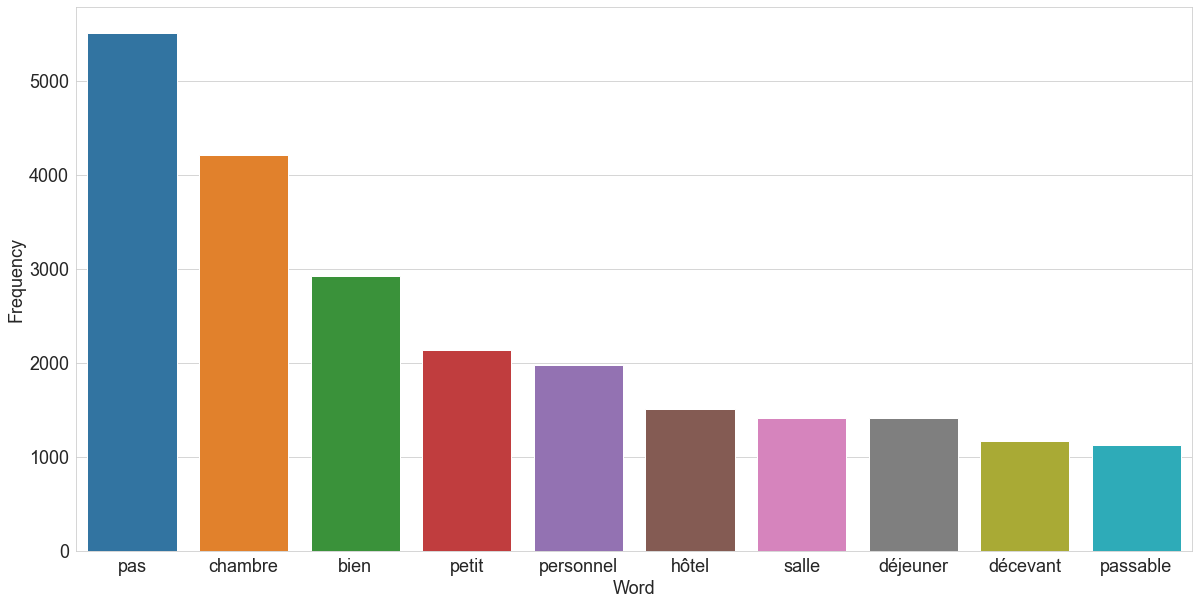

In [26]:
#histogramme des 10 mots les plus fréquents
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
sns.barplot(x="Word",y="Frequency", data=most_frequent)

In [27]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

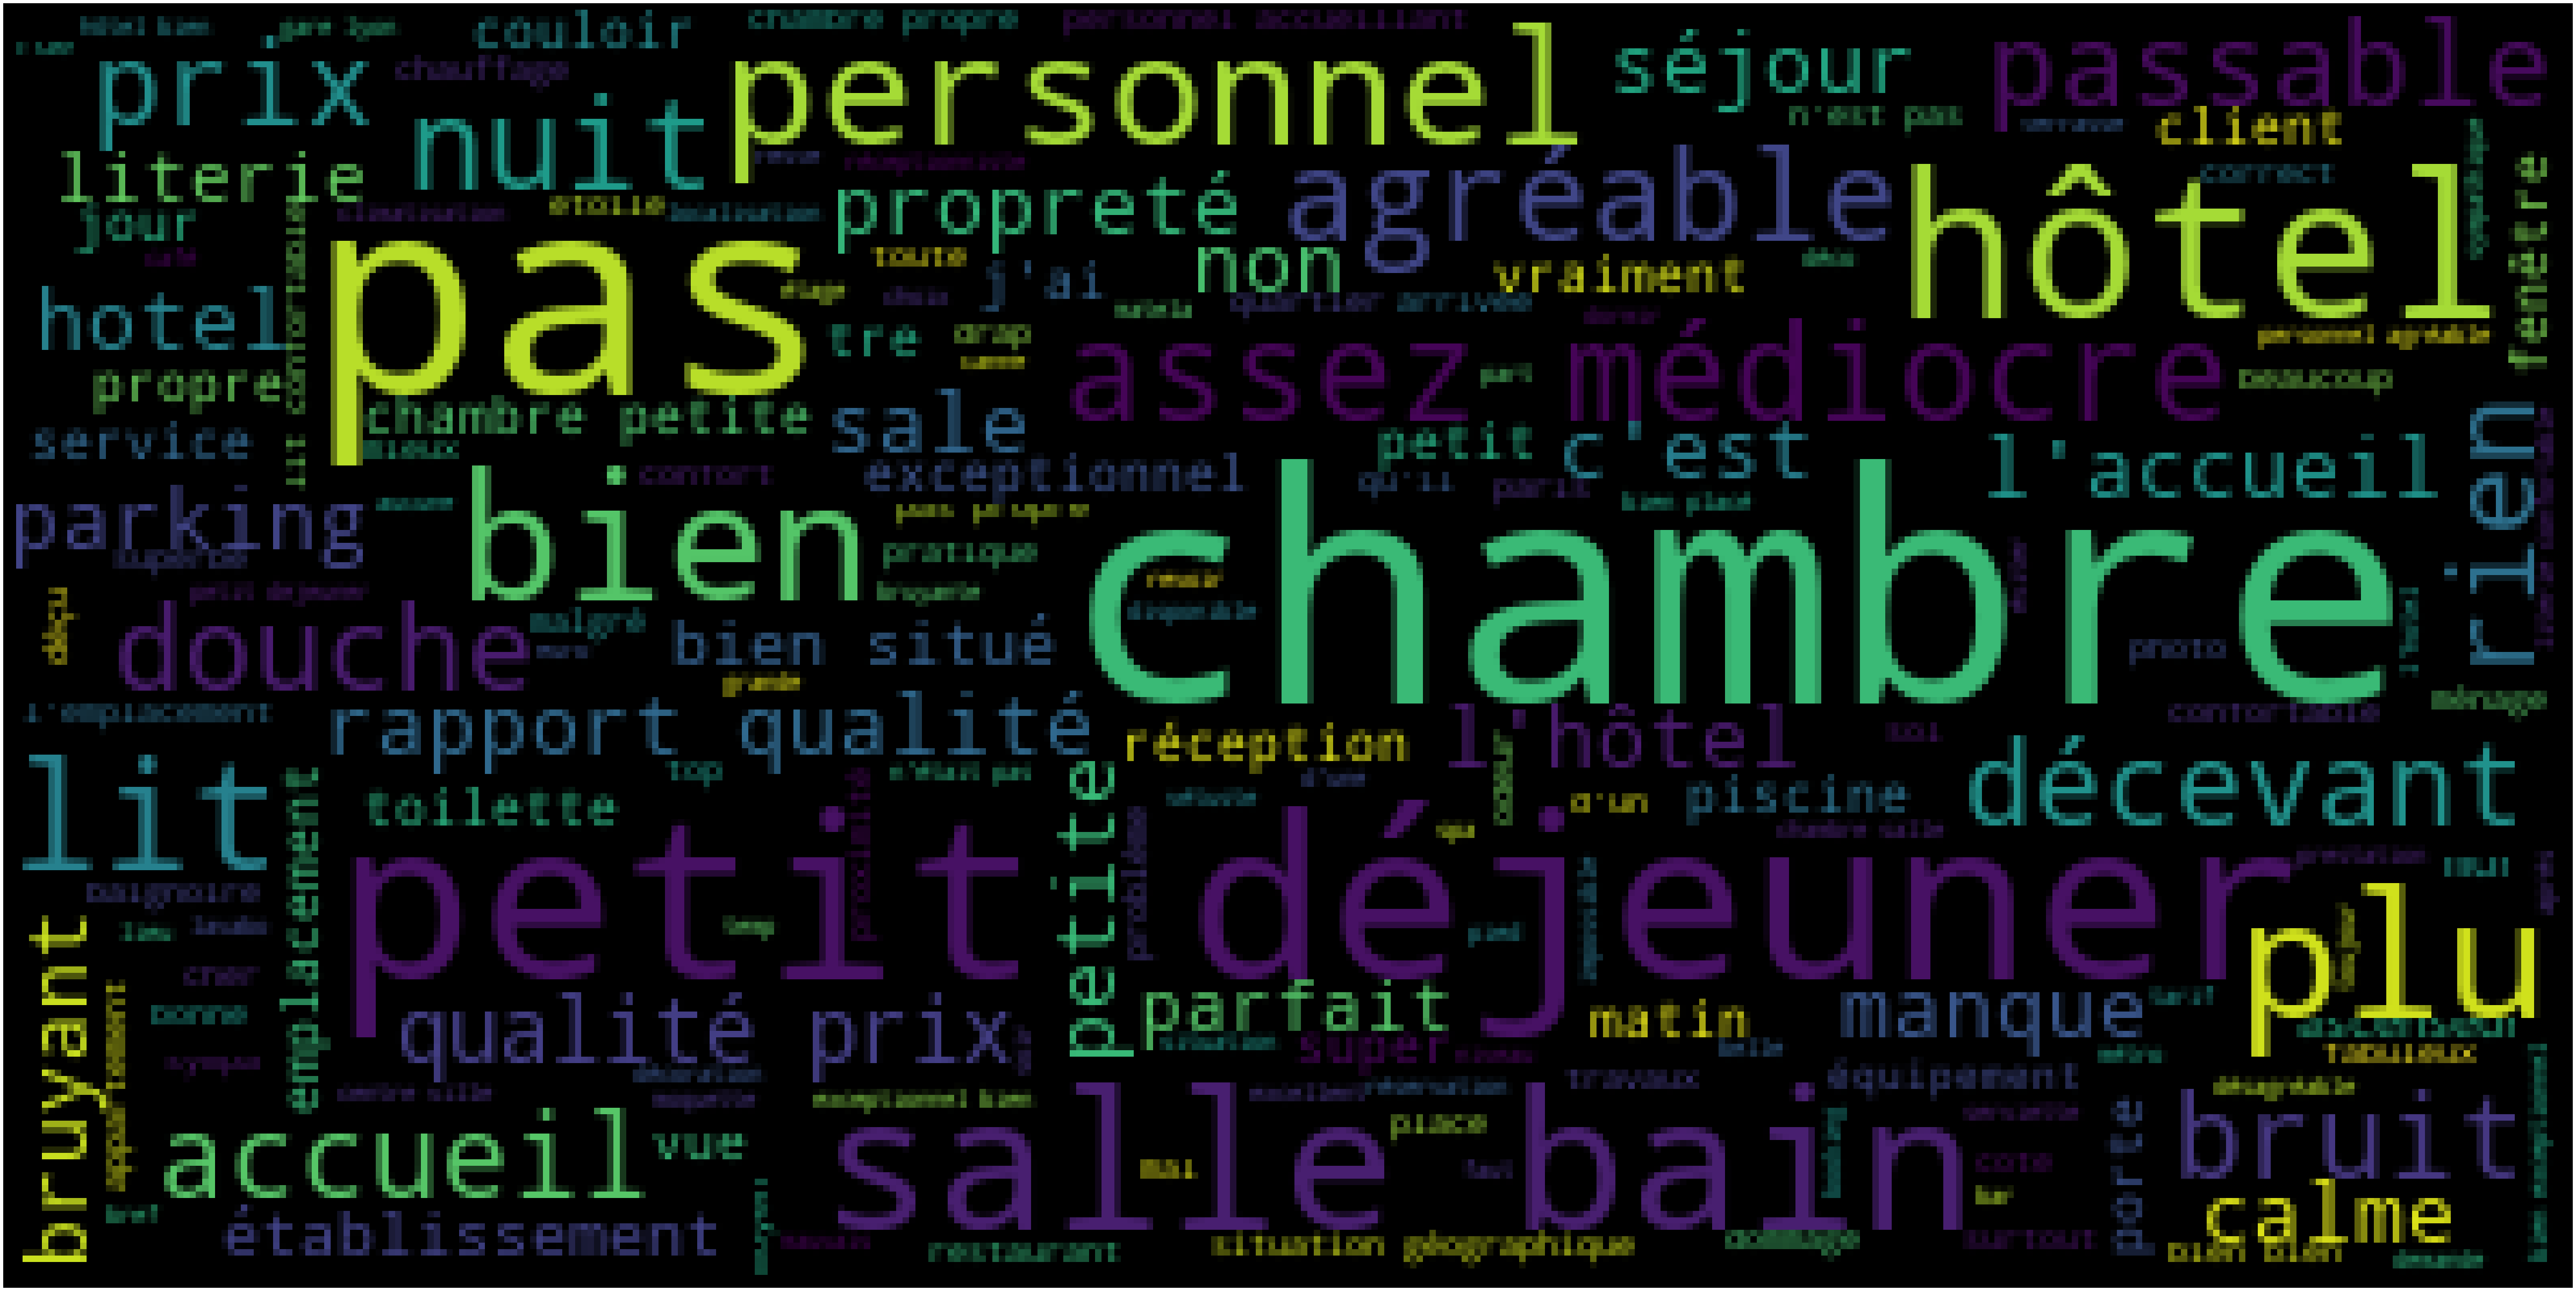

In [28]:
wcloud(all_words,'black','Common Words')

In [29]:
normalized_tokens[2]

['bien',
 'baignoir',
 'pied',
 'chambr',
 'film',
 'rapport',
 'qualité/prix',
 'paris',
 'pari']

### Save processed data to CSV file for modeling

In [32]:
processed_data = pd.DataFrame(data= {'review' : normalized_tokens, 'note' : df_small.note})
processed_data.to_csv('datasets/processed_data.csv', index=False)

,review,note
1,[superb],8.8
3,[bien],7.9
4,"[bien, baignoir, pied, chambr, film, rapport, ...",7.0
7,"[bien, personnel, agréabl, bon, liter, pet, dé...",7.5
9,[bien],7.0


,review,note
10412,"[passabl, lit, etroit, servic, nettoyag, jet, ...",5.0
10418,"[séjour, possibl, pas, vrai, envi, reven, sauf...",5.0
10421,"[assez, médiocr, l'emplac]",3.0
10422,[décev],4.2
10425,"[horribl, chambr, affreux, vieil, moquet, sal,...",5.0
